## Optimización de modelos

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils.base_models import BaseModels
from utils.categorical_encoders import CategoricalEncoders

from sklearn.ensemble import VotingClassifier, RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 0. Definir seed
seed = 16
np.random.seed(seed)

In [3]:
# 1. Leer el dataset
dataset = pd.read_parquet('./data/2_data_preprocesada.parquet')
dataset = dataset.drop(columns=['DF_TYPE'])

# Seleccionar aleatoriamente el 10% de los datos
dataset = dataset.sample(frac=0.002, random_state=42)
print(dataset.shape)
print(dataset['TARGET'].value_counts())

(2611, 14)
TARGET
0    1371
1    1240
Name: count, dtype: int64


In [10]:
# 2. Crear dataset con los encoders
categorical_encoders = CategoricalEncoders(dataset=dataset)
binary_columns, categorical_columns = categorical_encoders.get_binary_categorical_columns()

data = categorical_encoders.provider(binary_columns, categorical_columns, method='BackwardDifferenceEncoder')

# 3. Split dataset
X = data.drop(columns=['TARGET'])
y = data['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
# 4. Entrenar modelos
base_models = BaseModels()
name_models = ['logistic_regression', 'gradient_boosting', 'catboost', 'lgbm', 'xgboost', 'mlp', 'decision_tree']

all_models = []
all_results = []
all_predict_test = []
for i, model_name in enumerate(name_models):
    model = base_models.provider(model_name)
    model.fit(X_train, y_train)
    all_models.append(model)
    
    predict_train = model.predict_proba(X_train)[:, 1]
    predict_test = model.predict_proba(X_test)[:, 1]
    all_predict_test.append(predict_test)

    train_auc = roc_auc_score(y_train, predict_train)
    test_auc = roc_auc_score(y_test, predict_test)

    # Calcular accuracy, sensitivity, specificity
    test_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, test_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    gini = 2 * test_auc - 1

    all_results.append((model_name, train_auc, test_auc, accuracy, sensitivity, specificity, gini))

    print(f"{str(i).zfill(2)}: AUC on training data with {model_name}: {train_auc:.3f}")
    print(f"AUC on testing data with {model_name}: {test_auc:.3f}\n")

00: AUC on training data with logistic_regression: 0.816
AUC on testing data with logistic_regression: 0.776

01: AUC on training data with gradient_boosting: 0.893
AUC on testing data with gradient_boosting: 0.818

02: AUC on training data with catboost: 0.942
AUC on testing data with catboost: 0.823

[LightGBM] [Info] Number of positive: 982, number of negative: 1106
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470307 -> initscore=-0.118914
[LightGBM] [Info] Start training from score -0.118914
03: AUC on training data with lgbm: 0.971
AUC on testing data with lgbm: 0.808

04: AUC on training data with xgboost: 0.985
AUC on testing dat

In [12]:
# Validación cruzada (Cross-Validation)
model = RandomForestClassifier(n_estimators=100, random_state=seed)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

Cross-Validation Accuracy: 0.745 (+/- 0.038)


In [14]:
# Búsqueda en malla (Grid Search)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)
print(f"Best parameters from Grid Search: {grid_search.best_params_}")
print(f"Best score from Grid Search: {grid_search.best_score_:.3f}")

# Guardar resultados de Grid Search
best_gini_grid = 2 * grid_search.best_score_ - 1
best_auc_grid = grid_search.best_score_
best_accuracy_grid = grid_search.best_score_

Best parameters from Grid Search: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score from Grid Search: 0.768


In [15]:
# Búsqueda aleatoria (Random Search)
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11)
}
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=seed), param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=seed)
random_search.fit(X, y)
print(f"Best parameters from Random Search: {random_search.best_params_}")
print(f"Best score from Random Search: {random_search.best_score_:.3f}")

# Guardar resultados de Random Search
best_gini_random = 2 * random_search.best_score_ - 1
best_auc_random = random_search.best_score_
best_accuracy_random = random_search.best_score_

Best parameters from Random Search: {'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 4, 'n_estimators': 125}
Best score from Random Search: 0.770


In [16]:
# Guardar los mejores resultados de los modelos optimizados
consolidated_results = [
    ('grid_search', best_auc_grid, best_accuracy_grid, None, None, best_gini_grid),
    ('random_search', best_auc_random, best_accuracy_random, None, None, best_gini_random)
]

# Desempaquetar los resultados
all_names, all_test_aucs, all_accuracies, all_sensitivities, all_specificities, all_ginis = zip(*consolidated_results)


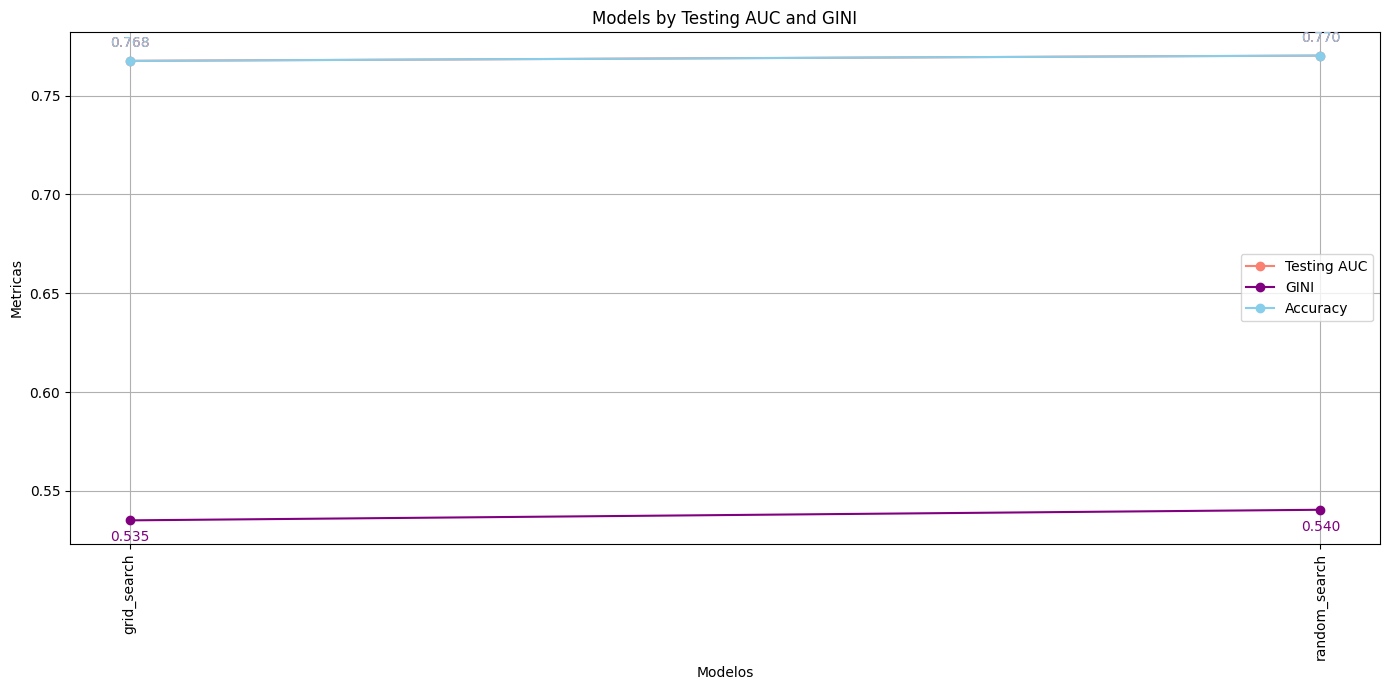

In [23]:
# Gráfico 1: GINI y AUC
plt.figure(figsize=(14, 7))
plt.plot(all_names, all_test_aucs, label='Testing AUC', marker='o', color='salmon')
plt.plot(all_names, all_ginis, label='GINI', marker='o', color='purple')
plt.plot(all_names, all_accuracies, label='Accuracy', marker='o', color='skyblue')

# Añadir los valores a los puntos
for i, txt in enumerate(all_test_aucs):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_test_aucs[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='red')
for i, txt in enumerate(all_ginis):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_ginis[i]), textcoords="offset points", xytext=(0, -15), ha='center', color='purple')
for i, txt in enumerate(all_accuracies):
    plt.annotate(f'{txt:.3f}', (all_names[i], all_accuracies[i]), textcoords="offset points", xytext=(0, 10), ha='center', color='skyblue')

plt.xlabel('Modelos')
plt.ylabel('Metricas')
plt.title('Models by Testing AUC and GINI')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
